In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import scipy

from PIL import Image

### find images

In [2]:
!ls data/images

123946.png 124105.png 124205.png 124245.png


In [3]:
# old_img_names = os.listdir(os.path.join("data", "images"))
cwd = os.getcwd()
# old_img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in old_img_names}

# for img in old_img_paths:
#     if "Screenshot" in img:
#         new_name = img[-10:]
#         new_path = os.path.join(cwd, "data", "images", new_name)
#         old_path = old_img_paths[img]
#         os.rename(old_path, new_path)

img_names = [img_name for img_name in os.listdir(os.path.join("data", "images")) if "png" in img_name]
cwd = os.getcwd()
img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in img_names}
img_paths.keys()

dict_keys(['123946.png', '124245.png', '124105.png', '124205.png'])

In [4]:
!ls /Users/jordansmith/Library/CloudStorage/OneDrive-Reply/CarbonIntensityProject/Carbon-Intensity-Project-/data/images

123946.png 124105.png 124205.png 124245.png


### import image

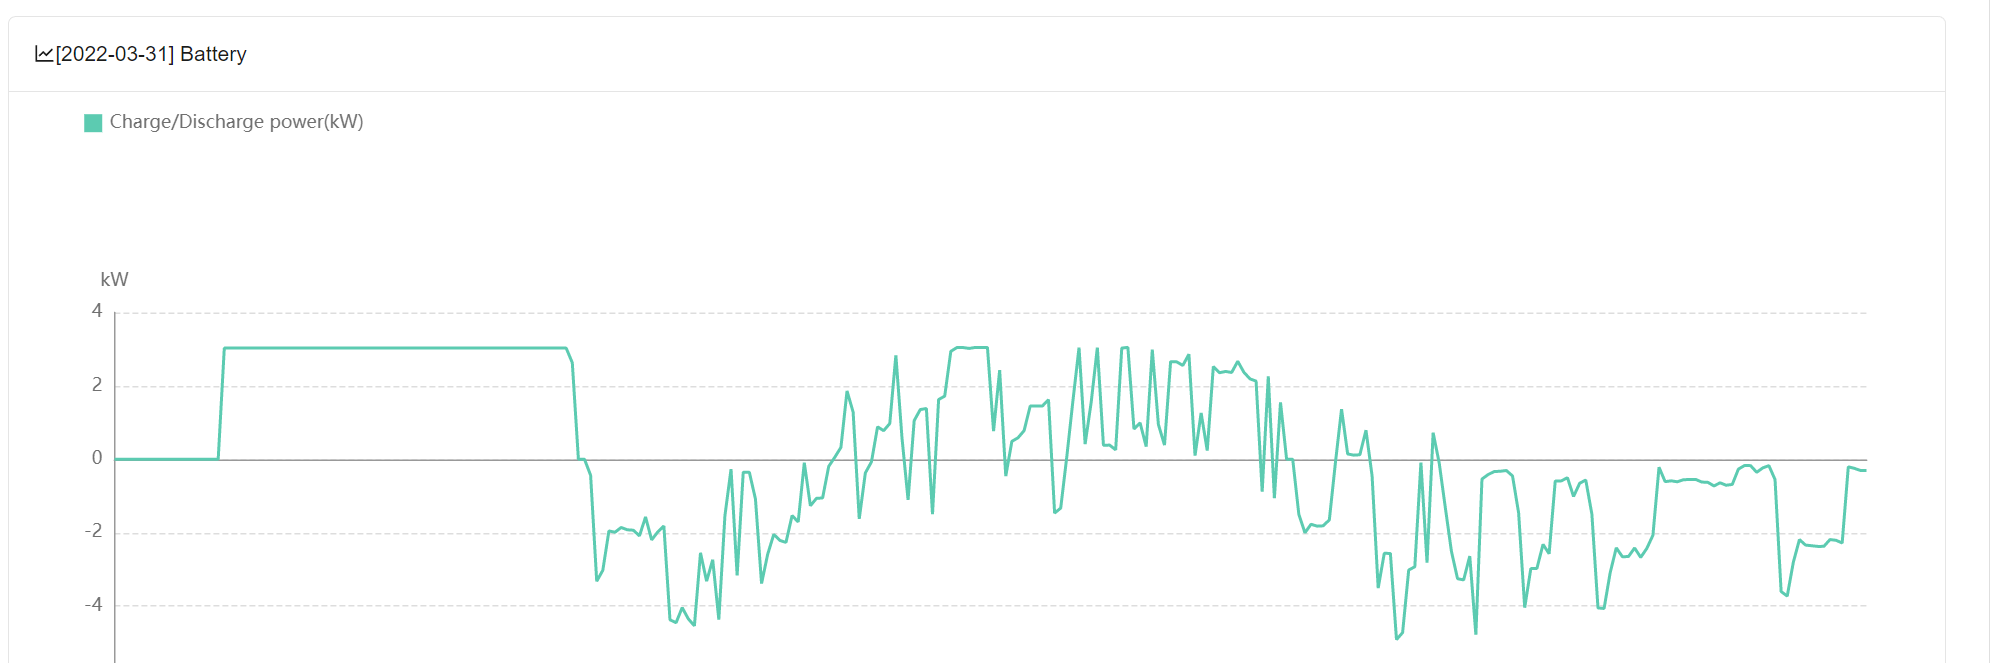

In [5]:
# exract the image
img = Image.open(img_paths[img_names[0]]).convert("RGB")
img_arr = np.asarray(img)

# generate dataframe and array of non-white pixel values 
non_white_values = np.argwhere(img_arr != 255)
list_pixel_values_subsection = []
for i in range(len(non_white_values)):
    vals_ = img_arr[non_white_values[i][0], non_white_values[i][1]]
    list_pixel_values_subsection.append(vals_)

col_names = ['r', 'g', 'b']
df = pd.DataFrame(list_pixel_values_subsection, columns=col_names)

# show the image
img

### plot colours and find rgb values of plot

(None, {'r': 92, 'g': 203, 'b': 177})

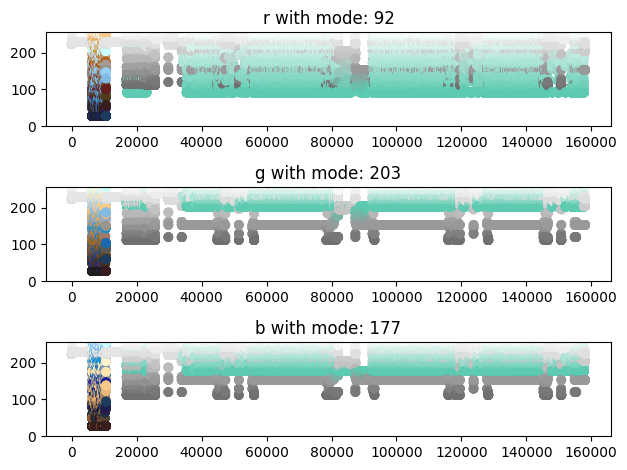

In [6]:
fig, axs = plt.subplots(3)
target_col_dict = {}
for i,col in enumerate(col_names):
    y = df[col]
    axs[i].scatter(np.arange(len(y)), y, label=col, c=np.array(df[col_names])/255)
    axs[i].set_title(f"{col} with mode: {y.mode().values[0]}")
    axs[i].set_ylim(0,255)
    target_col_dict[col] = y.mode().values[0]
    
fig.tight_layout(), target_col_dict

## find the grid axes lines

### convolve image with horizontal filter kernel

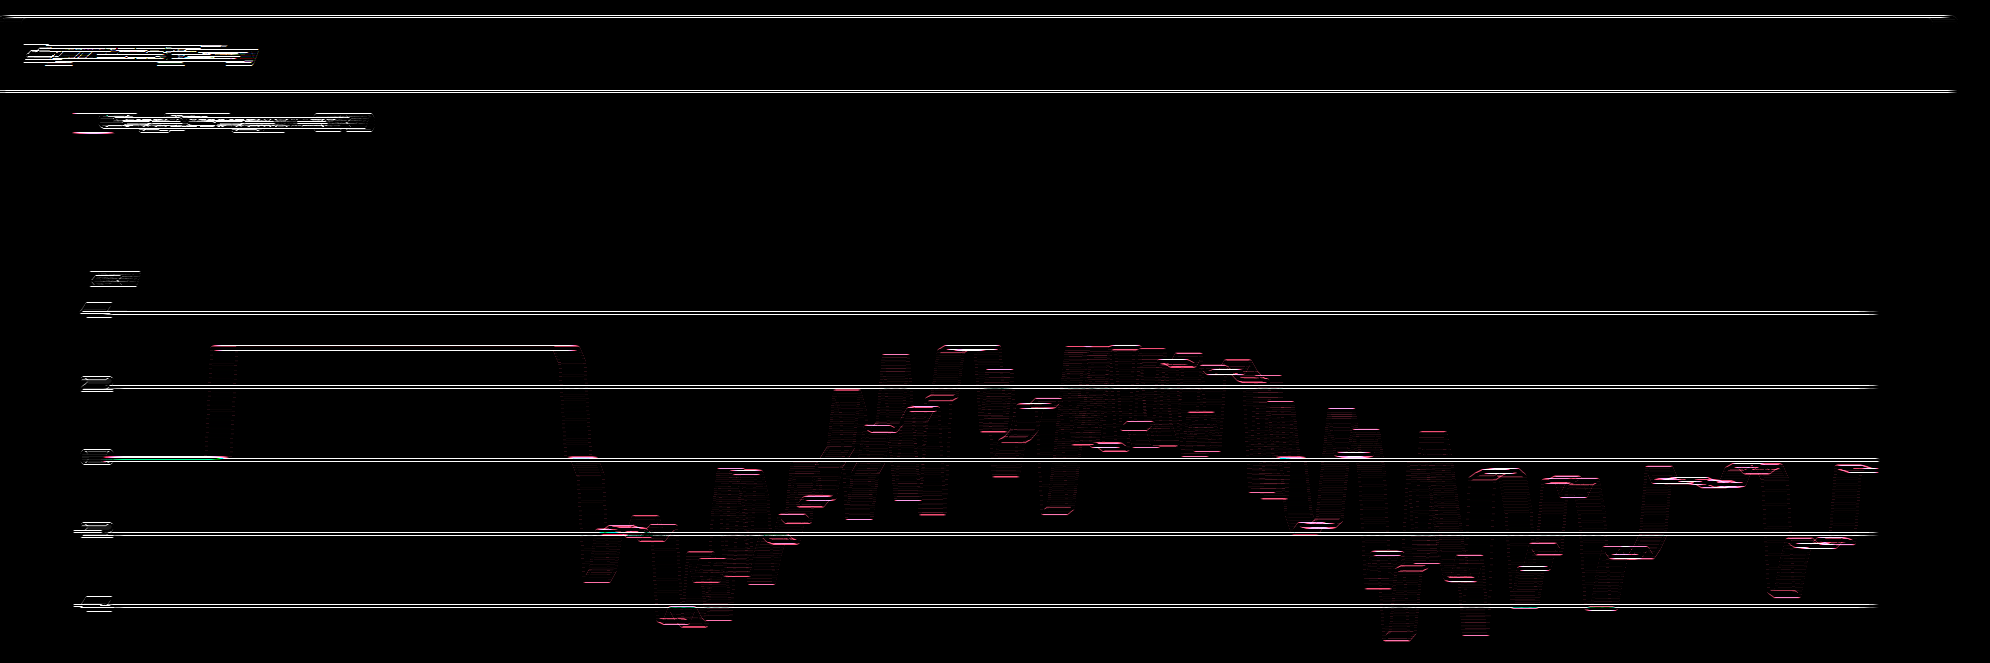

In [12]:
width = 25
convolution_kernel = np.array([[-1]*width, 
                               [2]*width, 
                               [-1]*width])

result = cv2.filter2D(img_arr, -1, convolution_kernel)
Image.fromarray(result)

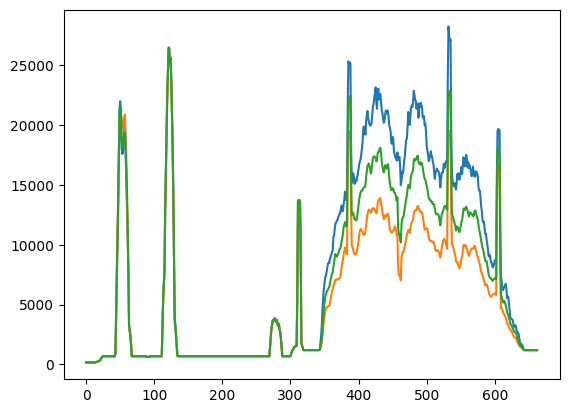

In [56]:
img_height = result.shape[0]
img_width = result.shape[1]

# calculate sum of response in horizontal direction
sum_arr_along_x = np.sum(result, axis=1)
plt.plot(sum_arr_along_x)

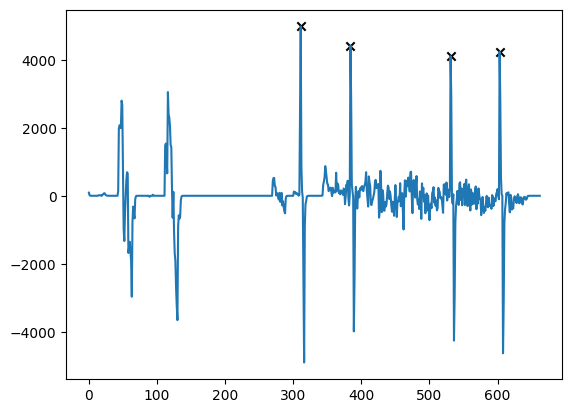

In [66]:
# remove the baseline wonder, uncomment above to see why
sos = scipy.signal.butter(1, 1, 'hp', fs=5, output='sos')
def hpf(a):
    return scipy.signal.sosfilt(sos, a)
filtered_sum_arr_along_x = np.apply_along_axis(hpf, 0, sum_arr_along_x)
plt.plot(r_arr)

# detect peaks
r_arr = filtered_sum_arr_along_x[:,0] # only run calculations on r component of pixel values
peaks_x = scipy.signal.find_peaks(r_arr, height=0.7*max(r_arr))[0]
peaks_y = r_arr[peaks_x]
plt.scatter(peaks_x, peaks_y, marker='x', c='black')

Picture this plot rotated 90 degrees clockwise, and then along the y axis of the image above. The peaks correspond to high sum of response along the x axis when the image was convolved with a horizontal filter. Therefore, peaks here correspond to rows along the original image with a lot of 'horizontalness' (highest values are just straight horizontal lines).

Clearly, the peaks identified correspond to the Y values on the plot of 4, 2, -2, -4.

In [71]:
# generate dictionary from these values
y_values_on_graph = [4,2,-2,-4] # !!!!!!!!!!!!!!!! CHECK THESE IN FUTURE
batter_charge_range = max(y_values_on_graph) - min(y_values_on_graph)
pixel_location_range = max(peaks_x) - min(peaks_x)
scaling_multiplier = batter_charge_range / pixel_location_range # kW per pixel


0.0273972602739726

### convolve image with horizontal filter kernel

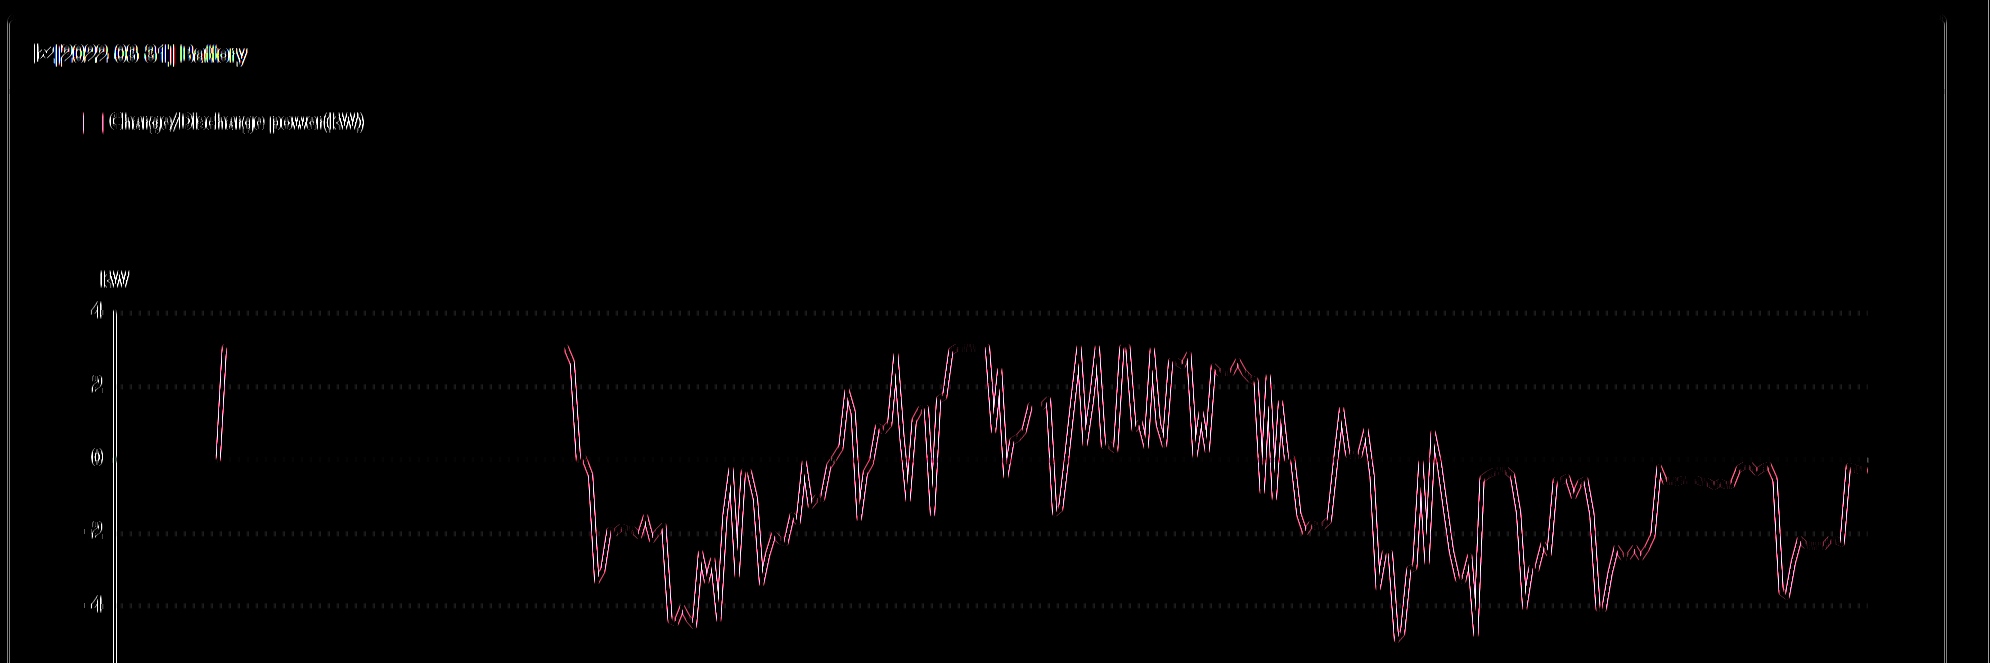

In [19]:
width = 5
convolution_kernel = np.array([[-1]*width, 
                               [2]*width, 
                               [-1]*width]).T

result = cv2.filter2D(img_arr, -1, convolution_kernel)
Image.fromarray(result)